In [78]:
using HDF5, FFTW, Statistics
using PyPlot
using LinearAlgebra
# pyplot()

In [2]:
arxname="../JLDFiles/Deshinibida/180116s1/180116s1cut_evento_1.h5"

"../JLDFiles/Deshinibida/180116s1/180116s1cut_evento_1.h5"

In [3]:
arx=h5open(arxname)

HDF5 data file: ../JLDFiles/Deshinibida/180116s1/180116s1cut_evento_1.h5

In [4]:
names(arx)

7-element Array{String,1}:
 "CMPNeg"          
 "CMPos"           
 "CSDLindenberg"   
 "CanalesSaturados"
 "Canalesrespuesta"
 "LFPTotal"        
 "freq"            

Todos los tiempos estan en cuadros, esto es, en 1/freq de segundo. Para las transformadas de Fourier (o graficas bonitas) tenemos que multiplicar los rangos por los factores adecuados.

In [5]:
lfp=read(arx, "LFPTotal")
saturados=read(arx, "CanalesSaturados")
buenos=read(arx, "Canalesrespuesta")
freq=read(arx, "freq")
#late=read(arx, "latencia")
#fin=read(arx,"final")
#retrazo=read(arx,"retrazo")
#println(freq, " ", late, " ", fin , " ", retrazo )

7.022058198545425

In [6]:
nmax=size(lfp)[3]

2001

In [7]:
iniact=retrazo+late # Retrazo + latencia = inicio de señal

UndefVarError: UndefVarError: retrazo not defined

In [8]:
#rango=iniact:fin
#mejor contamos desde cero, no? el momento cero es el inicial (aunque el indice no)!!!
rango=1:nmax

1:2001

In [9]:
buenos

863×2 Array{Int64,2}:
 38   5
 44   3
 53  36
 57  23
 56  30
 32  19
 38   6
 45   8
  4  32
 48  34
 54  28
 42  42
 43  38
  ⋮    
 51  30
 53  20
 44  26
 35  10
 28  16
 41  26
 30  14
 29   5
 59  28
 37  18
 44  28
 43  28

In [10]:
ejemplolfp=lfp[43,38,:];

In [11]:
tmax=nmax/freq
rangotiempos=(rango.-1)./freq
rangofreqs=(rango.-1)./tmax
rfreqsim=map(x->-freq/2+(x-1)*freq/(nmax-1),rango);
rfreqsim[1001]

0.0

In [12]:
rfreqsim[1000]

-0.003511029099272811

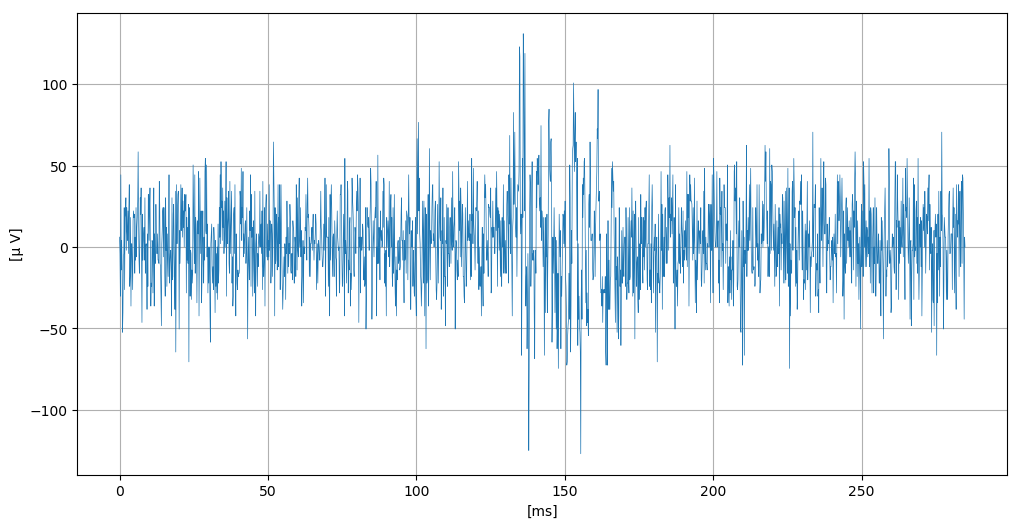

1-element Array{PyCall.PyObject,1}:
 PyObject <matplotlib.lines.Line2D object at 0x7ff0b7ea6710>

In [13]:
figura=figure(figsize=(12,6))
grid()
#xlim(120,170)
xlabel("[ms]")
ylabel("[μ V]")
plot(rangotiempos, ejemplolfp, lw=0.5)

In [14]:
?plan_fft

search: plan_fft plan_fft! plan_rfft plan_ifft plan_bfft plan_ifft! plan_bfft!



```
plan_fft(A [, dims]; flags=FFTW.ESTIMATE, timelimit=Inf)
```

Pre-plan an optimized FFT along given dimensions (`dims`) of arrays matching the shape and type of `A`.  (The first two arguments have the same meaning as for [`fft`](@ref).) Returns an object `P` which represents the linear operator computed by the FFT, and which contains all of the information needed to compute `fft(A, dims)` quickly.

To apply `P` to an array `A`, use `P * A`; in general, the syntax for applying plans is much like that of matrices.  (A plan can only be applied to arrays of the same size as the `A` for which the plan was created.)  You can also apply a plan with a preallocated output array `Â` by calling `mul!(Â, plan, A)`.  (For `mul!`, however, the input array `A` must be a complex floating-point array like the output `Â`.) You can compute the inverse-transform plan by `inv(P)` and apply the inverse plan with `P \ Â` (the inverse plan is cached and reused for subsequent calls to `inv` or `\`), and apply the inverse plan to a pre-allocated output array `A` with `ldiv!(A, P, Â)`.

The `flags` argument is a bitwise-or of FFTW planner flags, defaulting to `FFTW.ESTIMATE`. e.g. passing `FFTW.MEASURE` or `FFTW.PATIENT` will instead spend several seconds (or more) benchmarking different possible FFT algorithms and picking the fastest one; see the FFTW manual for more information on planner flags.  The optional `timelimit` argument specifies a rough upper bound on the allowed planning time, in seconds. Passing `FFTW.MEASURE` or `FFTW.PATIENT` may cause the input array `A` to be overwritten with zeros during plan creation.

[`plan_fft!`](@ref) is the same as [`plan_fft`](@ref) but creates a plan that operates in-place on its argument (which must be an array of complex floating-point numbers). [`plan_ifft`](@ref) and so on are similar but produce plans that perform the equivalent of the inverse transforms [`ifft`](@ref) and so on.


In [15]:
plan=plan_fft(ejemplolfp,  flags=FFTW.PATIENT)
fttotal=(plan*ejemplolfp);
ftsym=circshift(fttotal, div(nmax,2));

In [16]:
div(102,2)

51

In [17]:
epoder=map(abs2, ftsym);

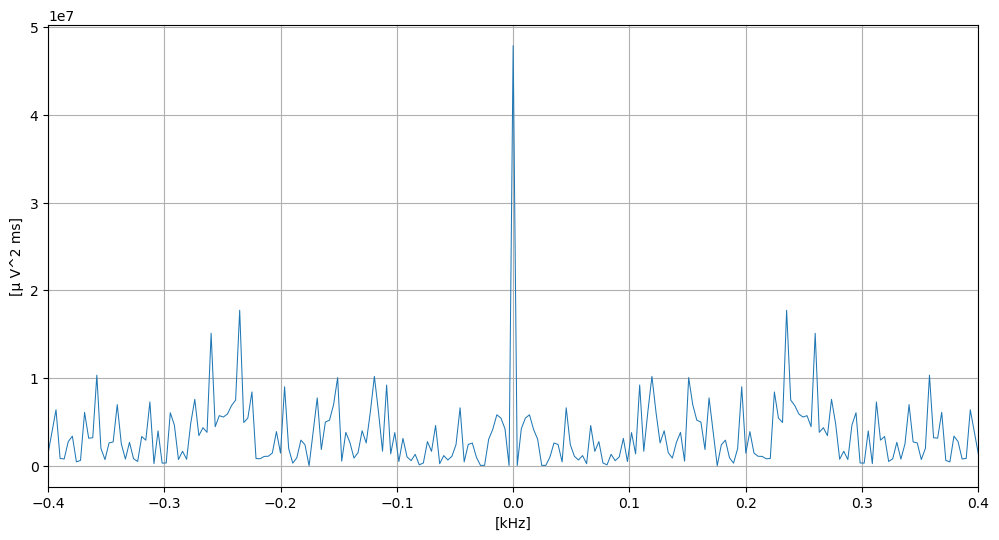

1-element Array{PyCall.PyObject,1}:
 PyObject <matplotlib.lines.Line2D object at 0x7ff0b355ba58>

In [76]:
figura=figure(figsize=(12,6))
grid(which="both")
xlim(-0.4,0.4)
xlabel("[kHz]")
ylabel("[μ V^2 ms]")
#yscale("log")
mediorango=1:500
plot(rfreqsim,epoder, lw=0.74)
#plot(rangofreqs[mediorango],epoder2[mediorango])

In [19]:
function indicecercano(a::Number, freqs::Array)
    #encuentra en índice que tiene el número  más cercano a "a" en el Array freqs
    # si a está más lejos de alguno de ellos que su paso
    tol=abs((max(freqs)-min(freqs))/length(freqs))
    result=findfirst(x->isapprox(a,x, atol=tol), freqs)
    return result
end

function indicecercano(a::Number, freqs::StepRangeLen)
    #encuentra en índice que tiene el número  más cercano a "a" en el Array freqs
    # si a está más lejos de alguno de ellos que su paso
    tol=step(freqs)
    result=findfirst(x->isapprox(a,x, atol=tol), freqs)
    return result
end


indicecercano (generic function with 2 methods)

In [27]:
?iseven

search: iseven isinteractive



```
iseven(x::Integer) -> Bool
```

Return `true` is `x` is even (that is, divisible by 2), and `false` otherwise.

# Examples

```jldoctest
julia> iseven(9)
false

julia> iseven(10)
true
```


In [81]:
function filtrobanda(freqs, yys::Array, a::Float64, b::Float64 )
    #filtro pasa banda para DFT anular con rango [0, freqmax)
    if a>b
        b,a=a,b
    end
    abajo=indicecercano(a,freqs)
    arriba=indicecercano(b, freqs)
    result=deepcopy(yys)
    l=length(yys)
    laux=l+1
    if !(iseven(l))
        #ajustar indices
        laux+=1
    end
   # println( "los indices aceptables seran: ")
   # println( "abajo = ", abajo, " arriba = ", arriba, " laux-arriba = ", laux-arriba, " laux - abajo =", laux-abajo)
    for w in 1:l
        if ! (( abajo < w < arriba ) || (laux-arriba)<w<(laux-abajo) )
        result[w]=0
        end
    end
    return result
end

filtrobanda (generic function with 1 method)

In [61]:
rangofreqs.step

Base.TwicePrecision{Float64}(0.003509274462041692, 0.0)

In [62]:
rara2=filtrobanda(rangofreqs, fttotal, 0.001,0.05);

los indices aceptables seran: 
abajo = 1 arriba = 15 laux-arriba = 1988 laux - abajo =2002


In [63]:
fttotal[2:14]

13-element Array{Complex{Float64},1}:
  136.48315111440212 - 60.28345245771507im 
   261.8093166811417 + 2036.1922769266293im
 -1259.2325028683504 - 1962.4162723842996im
    1491.23470812692 + 1892.567979244483im 
  -1351.387059172689 - 1522.4783058920634im
     1219.7875707673 + 1237.8035041436062im
  -194.0513681720272 - 55.76399730304175im 
  -174.3366264619329 + 88.69835447262493im 
   818.4487849329419 - 542.9053024313612im 
  -654.4261788067222 + 1469.2587911842693im
   60.05255433672721 - 1558.029107933492im 
  -658.9069957031631 + 54.127633771127876im
   2017.978724639123 - 1591.87569429435im  

In [64]:
fttotal[1989:2001]

13-element Array{Complex{Float64},1}:
   2017.978724639123 + 1591.8756942943505im
  -658.9069957031631 - 54.12763377112758im 
  60.052554336727695 + 1558.0291079334918im
   -654.426178806722 - 1469.2587911842693im
   818.4487849329419 + 542.9053024313615im 
 -174.33662646193295 - 88.69835447262463im 
 -194.05136817202765 + 55.76399730304172im 
  1219.7875707672993 - 1237.8035041436065im
 -1351.3870591726889 + 1522.4783058920632im
  1491.2347081269204 - 1892.5679792444832im
 -1259.2325028683501 + 1962.4162723842996im
  261.80931668114215 - 2036.192276926629im 
  136.48315111440235 + 60.283452457715im   

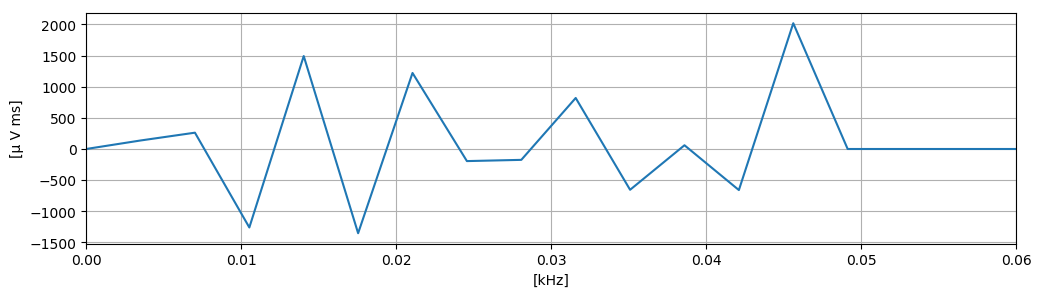

1-element Array{PyCall.PyObject,1}:
 PyObject <matplotlib.lines.Line2D object at 0x7ff0b3671160>

In [65]:

figura=figure(figsize=(12,3))
grid(which="both")
xlim(-0.0,0.06)
xlabel("[kHz]")
ylabel("[μ V ms]")
plot(rangofreqs, real(rara2))

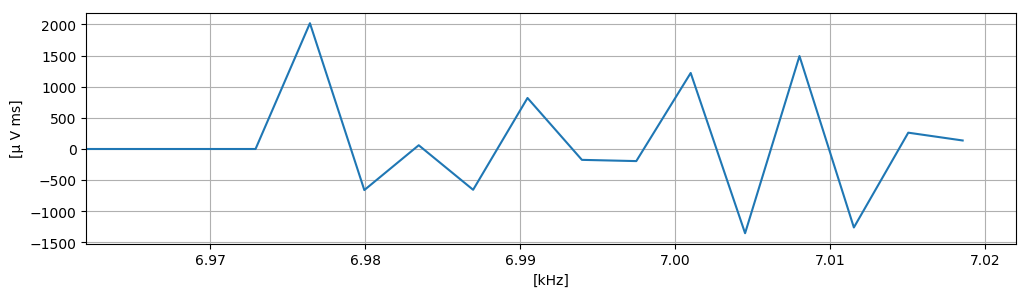

1-element Array{PyCall.PyObject,1}:
 PyObject <matplotlib.lines.Line2D object at 0x7ff0b35477f0>

In [68]:

figura=figure(figsize=(12,3))
grid(which="both")
xlim(7.022-0.06, 7.022)
xlabel("[kHz]")
ylabel("[μ V ms]")
plot(rangofreqs, real(rara2))

Muy bien, hasta ahí parece funcionar. Hay que checar que esto también jale con indices pares. Ahora aplicamos a esto a los datos completos.

In [74]:
ffTotalTotal=zeros(Complex, 64, 64, nmax);
for j=1:64, k=1:64
    ffTotalTotal[j,k,:]=plan*vec(lfp[j,k,:])
end

In [82]:
# = funciones auxiliares para bandas "ineteresantes =#
fbajas(datos)=filtrobanda(rangofreqs,datos, 0.010, 0.060)
fmedias(datos)=filtrobanda(rangofreqs, datos, 0.1, 0.2)
faltas(datos)=filtrobanda(rangofreqs, datos, 0.2, 0.3)
faltotas(datos)=filtrobanda(rangofreqs, datos, 0.3, 0.45)

faltotas (generic function with 1 method)

In [97]:
poderbajo=zeros(Real, 64,64)
podermedio=zeros(Real, 64,64)
poderalto=zeros(Real, 64,64)
poderaltote=zeros(Real, 64,64)
for j=1:64, k=1:64
    aux=fbajas(ffTotalTotal[j,k,:])
    poderbajo[j,k]=convert(Real, dot(aux,aux))
    aux=fmedias(ffTotalTotal[j,k,:])
    podermedio[j,k]=convert(Real, dot(aux,aux))
    aux=faltas(ffTotalTotal[j,k,:])
    poderalto[j,k]=convert(Real, dot(aux,aux))
    aux=faltotas(ffTotalTotal[j,k,:])
    poderaltote[j,k]=convert(Real, dot(aux,aux))
end

In [90]:
extrema(poderbajo)

(3.638305939812023e6, 2.8371005773256445e12)

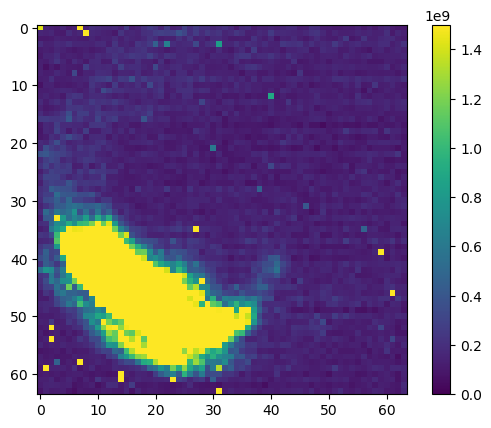

PyObject <matplotlib.colorbar.Colorbar object at 0x7ff0969a5208>

In [101]:
imshow(poderaltote, vmin=0, vmax=15e8)
colorbar()

In [69]:
rplan=plan_ifft(rara2);

In [70]:
signalfiltrad2=rplan*rara2

2001-element Array{Complex{Float64},1}:
 1.7125977805234094 - 2.1305629258173918e-17im
 1.7789348777585041 + 6.14312310277348e-16im  
 1.8426069405890277 + 5.397426078737392e-16im 
 1.9034901024190556 + 5.93006681019174e-16im  
 1.9614651390259363 + 7.492479622457827e-16im 
 2.0164176643415606 + 6.817801362615654e-16im 
 2.0682383179395236 + 3.266863152920001e-16im 
  2.116822943927605 + 6.74678259842174e-16im  
 2.1620727609597314 + 5.823538663900871e-16im 
 2.2038945230967952 + 1.278337755490435e-16im 
   2.24220067126132 - 3.550938209695653e-16im 
  2.276909475047027 + 4.971313493573914e-16im 
  2.307945164660738 + 8.522251703269567e-17im 
                    ⋮                         
 0.7591569853020808 + 1.1612803364624002e-15im
 0.8464223963549309 + 1.1175727353924609e-15im
 0.9327901705446965 + 3.3941245635124027e-16im
 1.0180985544897598 + 8.458400273455289e-16im 
 1.1021875681200837 + 4.2616333140899324e-16im
 1.1848992719003548 - 1.9191108775466552e-16im
 1.2660780303183867 

In [42]:
devuelta=rplan*fttotal

2001-element Array{Complex{Float64},1}:
        6.04248046874999 - 5.681501135513045e-15im 
      -4.028320312500002 - 7.0359585496605274e-15im
     -30.212402343749993 + 8.29497933881589e-15im  
           44.3115234375 + 1.020412308736249e-15im 
     -14.099121093749998 - 3.719073191581071e-15im 
       4.028320312500009 + 6.180185250241311e-15im 
     -12.084960937500002 - 3.9741918837543914e-15im
          -52.3681640625 + 2.8275189023048848e-15im
      -40.28320312500001 - 9.847420910979075e-16im 
      -6.042480468749993 + 7.478423600084474e-16im 
      -4.028320312499995 - 9.068339104632982e-15im 
      24.169921875000004 - 4.132350093950434e-15im 
     -26.184082031249986 - 1.0070642676037475e-15im
                         ⋮                         
      -6.042480468750007 + 7.92558266784124e-15im  
     -12.084960937500004 + 1.4354809253533387e-14im
      34.240722656249986 + 4.670384610522701e-15im 
       40.28320312499999 - 7.628045542244041e-15im 
         -10.07080078125

In [44]:
maximum(imag(devuelta))

1.890851685166271e-14

In [45]:
maximum(real(devuelta))

130.92041015624997

In [38]:
maximum(imag(signalfiltrad2))

0.8495663642689305

In [39]:
maximum(real(signalfiltrad2))

15.770649918554879

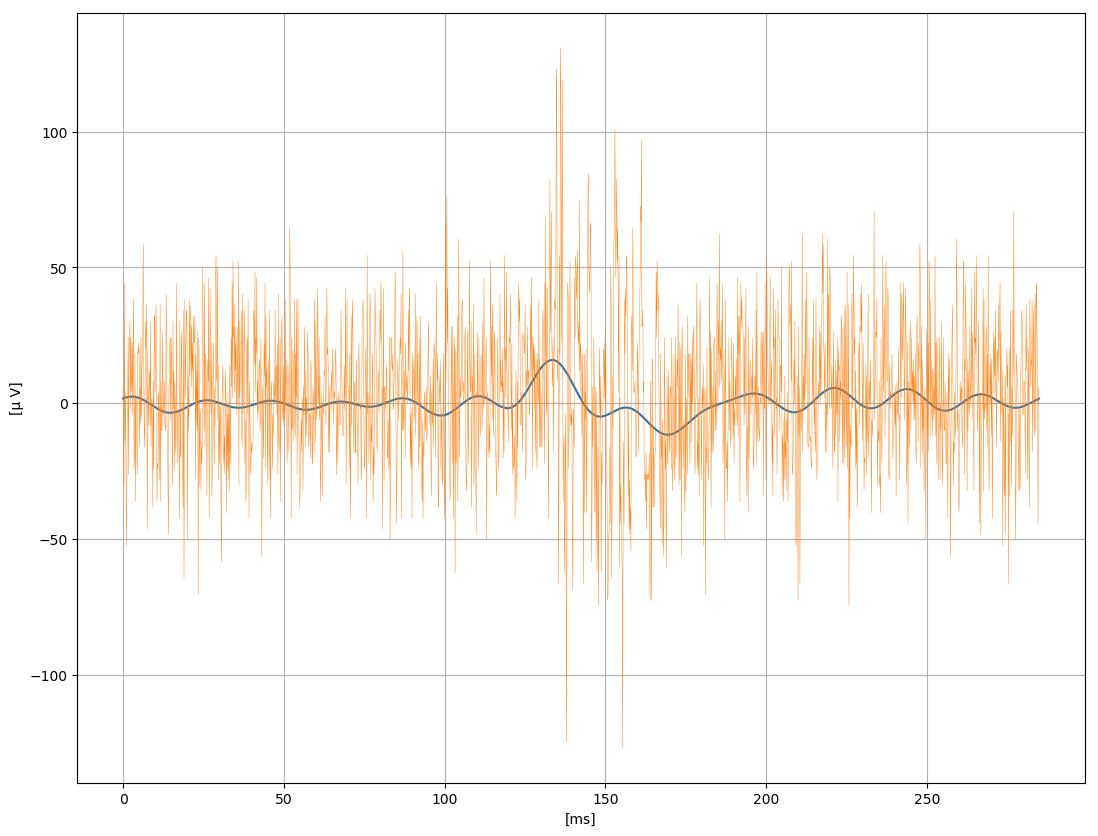

1-element Array{PyCall.PyObject,1}:
 PyObject <matplotlib.lines.Line2D object at 0x7ff0b3453320>

In [71]:
figura=figure(figsize=(13,10))
grid()
#xlim(120,170)
xlabel("[ms]")
ylabel("[μ V]")
#plot(rangotiempos, signalfiltrad, lw=1.5)
plot(rangotiempos, signalfiltrad2, lw=1.5)
#plot(rangotiempos, signalfiltrad+signalfiltrad2, lw=1.65)
plot(rangotiempos, ejemplolfp, lw=0.3)


In [29]:
a=0.053022
tol=2*step(rangofreqs)
q(x)=isapprox(a,x, atol=tol)
findfirst(q, rangofreqs)


14

In [30]:
rangofreqs[12:17]

0.0421112935445003:0.003509274462041692:0.05965766585470876

In [31]:
map(q, rangofreqs[12:17])

6-element Array{Bool,1}:
 false
 false
  true
  true
  true
  true

In [32]:
collect(rangofreqs[12:17])

6-element Array{Float64,1}:
 0.0421112935445003  
 0.045620568006541996
 0.049129842468583686
 0.05263911693062538 
 0.05614839139266707 
 0.05965766585470876 

In [33]:
step(rangofreqs)

0.003509274462041692

In [34]:
a=0.005
p=indicecercano(a, rangofreqs)

1

In [35]:
rangofreqs[2]

0.007018548924083384

In [36]:
rangofreqs[57]

0.20002864433637643

In [37]:
figura=figure(figsize=(12,6))
grid()
xlabel("[kHz]")
ylabel("[μ V^2]")
plot(subfreqs,epoder2)

UndefVarError: UndefVarError: subfreqs not defined